In [33]:
import numpy as np
import g2o
import cv2
from helper_functions import *
import pangolin
import OpenGL.GL as gl
import time
import os 
from pathlib import Path
import re

class FeatureExtractor:
    def __init__(self):
        self.extractor = cv2.SIFT_create()
        
    def compute_features(self, img):
        pts = cv2.goodFeaturesToTrack(np.mean(img, axis=2).astype(np.uint8), 3000, qualityLevel=0.01, minDistance=7)
        kps = [cv2.KeyPoint(x=f[0][0], y=f[0][1], size=20) for f in pts]
        kp, des = self.extractor.compute(img, kps)
        return kp, des
        
        #kp, des = self.extractor.detectAndCompute(img,None)
        #return kp, des


class FeatureMatcher():
    def __init__(self):
        self.matcher = cv2.BFMatcher()
    def match_features(self, frame_cur, frame_prev):
        kp1, desc1 = frame_cur.keypoints, frame_cur.features
        kp2, desc2 = frame_prev.keypoints, frame_prev.features
        # Match descriptors.
        matches = self.matcher.knnMatch(desc1,desc2,k=1)
        # Sort the matches according to nearest neighbor distance ratio (NNDR) (CV course, exercise 4)
        distmat = np.dot(desc1, desc2.T)
        X_terms = np.expand_dims(np.diag(np.dot(desc1, desc1.T)), axis=1)
        X_terms = np.tile(X_terms,(1,desc2.shape[0]))
        Y_terms = np.expand_dims(np.diag(np.dot(desc2, desc2.T)), axis=0)
        Y_terms = np.tile(Y_terms,(desc1.shape[0],1))
        distmat = np.sqrt(Y_terms + X_terms - 2*distmat)
        ## We determine the mutually nearest neighbors
        dist1 = np.amin(distmat, axis=1)
        ids1 = np.argmin(distmat, axis=1)
        dist2 = np.amin(distmat, axis=0)
        ids2 = np.argmin(distmat, axis=0)
        pairs = []
        for k in range(ids1.size):
            if k == ids2[ids1[k]]:
                pairs.append(np.array([k, ids1[k], dist1[k]]))
        pairs = np.array(pairs)
        # We sort the mutually nearest neighbors based on the nearest neighbor distance ratio
        NNDR = []
        for k,ids1_k,dist1_k in pairs:
            r_k = np.sort(distmat[int(k),:])
            nndr = r_k[0]/r_k[1]
            NNDR.append(nndr)

        id_nnd = np.argsort(NNDR)
        return np.array(matches)[id_nnd]


class Frame:
    def __init__(self, rgb_fp, d_path, feature_extractor):
        self.rgb = cv2.imread(rgb_fp)
        self.depth = cv2.imread(d_path)
        self.keypoints, self.features  = None, None
        self.feature_extractor = feature_extractor
    def process_frame(self):
        self.keypoints, self.features = self.feature_extract(self.rgb)
        return self.keypoints, self.features, self.rgb
        
    def feature_extract(self, rgb):
        return self.feature_extractor.compute_features(rgb)
        

if __name__=="__main__":
    # Global variables
    debug = True
    scale = 5000
    D = np.array([0, 0, 0, 0], dtype=np.float32)  # no distortion
    K = np.matrix([[481.20, 0, 319.5], [0, 480.0, 239.5], [0, 0, 1]])  # camera intrinsic parameters
    fx, fy, cx, cy = 481.20, 480.0, 319.5, 239.5
    # Filepaths
    cur_dir = "/home/juuso"
    dir_rgb = cur_dir + "/visual_slam/data/ICL_NUIM/rgb/"
    dir_depth = cur_dir + "/visual_slam/data/ICL_NUIM/depth/"
    is_WINDOWS = False
    if is_WINDOWS:
        dir_rgb = dir_rgb.replace("/", "\\")
        dir_depth = dir_depth.replace("/", "\\")
    # Initialize
    feature_extractor = FeatureExtractor()
    feature_matcher = FeatureMatcher()
    trajectory = [np.array([0, 0, 0])] # camera trajectory for visualization
    poses = [np.eye(4)]
    # run feature extraction for 1st image
    fp_rgb = dir_rgb + str(1) + ".png"
    fp_depth = dir_depth + str(1) + ".png"
    cur_frame = Frame(fp_rgb, fp_depth, feature_extractor)
    kp, features, rgb = cur_frame.process_frame() 
    prev_frame = cur_frame
    
    
    for i in range(1,500):
        if i % 20 == 0:
            fp_rgb = dir_rgb + str(i) + ".png"
            fp_depth = dir_depth + str(i) + ".png"
            # Feature Extraction for current frame
            cur_frame = Frame(fp_rgb, fp_depth, feature_extractor)
            kp, features, rgb = cur_frame.process_frame()
            # Feature Matching to previous frame
            matches = feature_matcher.match_features(prev_frame, cur_frame)    
            # if not enough matches (<100) continue to next frame
            if(len(matches) < 100):
                print("too few matches")
                continue
            # match and normalize keypoints
            preMatchedPoints, curMatchedPoints = MatchAndNormalize(prev_frame.keypoints, cur_frame.keypoints, matches, K)
            # compute homography and inliers
            H, inliersH  = estimateHomography(preMatchedPoints, curMatchedPoints, homTh= K[0,0]) # ransac threshold as last argument
            # compute essential and inliers
            E, inliersE  = estimateEssential(preMatchedPoints, curMatchedPoints, essTh=K[0,0])
            # choose between models based on number of inliers
            # https://www.programcreek.com/python/example/70413/cv2.RANSAC
            tform = H
            inliers = inliersH
            tform_type = "Homography"
            if sum(inliersH) < 1000000: #sum(inliersE):
                print("Chose Essential")
                tform = E
                inliers = inliersE
                tform_type = "Essential"
            else:
                print("chose Homography")
            # if number of inliers with the better model too low continue to next frame
            if sum(inliers) < 100:
                print("too few inliers")
                continue
            # else continue with the inliers
            #print(inliers)
            #print(np.shape(preMatchedPoints))
            inlierPrePoints = preMatchedPoints[inliers[:, 0] == 1, :]
            inlierCurrPoints = curMatchedPoints[inliers[:, 0] == 1, :]
            # get pose transformation (use only half of the points for faster computation)
            R,t, validFraction = estimateRelativePose(tform, preMatchedPoints, curMatchedPoints, K, tform_type)
            print("estRel")
            print(R)
            print(t)
            points, R, t, inliers = cv2.recoverPose(tform, inlierPrePoints, inlierCurrPoints, cameraMatrix=K)
            print("recoverpose")
            print(R)
            print(t)
            # according to https://answers.opencv.org/question/31421/opencv-3-essentialmatrix-and-recoverpose/
            RelativePoseTransformation = np.linalg.inv(np.vstack((np.hstack((R,t)), np.array([0,0,0,1]))))
            pose = RelativePoseTransformation @ poses[-1]
            poses.append(pose)
            new_xyz = trajectory[-1] + pose[:3,3]
            trajectory.append(new_xyz)
            """
            print("Rotation: ")
            print(R)
            print("Translation: ")
            print(t)
            
            print("valid fraction: ")
            print(validFraction)
            print("number of solutions: ")
            print(len(r))
            """
            # TODO: triangulate two view to obtain 3-D map points
            # Display
            img3 = cv2.drawMatchesKnn(prev_frame.rgb,prev_frame.keypoints, cur_frame.rgb,cur_frame.keypoints,matches[:100],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            #img2 = cv2.drawKeypoints(rgb, kp, None, color=(0,255,0), flags=0)
            cv2.imshow('a', img3)
            cv2.waitKey(1)
            prev_frame = cur_frame

Chose Essential
estRel
[ 0.99985728 -0.0092984   0.01410555]
[-0.80983449]
recoverpose
[[ 0.99985728 -0.0092984   0.01410555]
 [ 0.00924284  0.99994929  0.00399856]
 [-0.01414202 -0.00386762  0.99989252]]
[[-0.80983449]
 [-0.11515945]
 [ 0.57524464]]
Chose Essential
estRel
[ 0.99495878 -0.01885619 -0.09849601]
[0.91806562]
recoverpose
[[ 0.99495878 -0.01885619 -0.09849601]
 [ 0.01923191  0.99981094  0.00286646]
 [ 0.09842334 -0.00474628  0.99513332]]
[[ 0.91806562]
 [ 0.17989085]
 [-0.35326308]]
Chose Essential
estRel
[ 0.99100968 -0.02730894 -0.13097345]
[0.98590634]
recoverpose
[[ 0.99100968 -0.02730894 -0.13097345]
 [ 0.02865236  0.99955428  0.00838336]
 [ 0.13068613 -0.01206069  0.99135043]]
[[ 0.98590634]
 [ 0.13854304]
 [-0.09377907]]
Chose Essential
estRel
[ 0.98845017 -0.03892165 -0.14646283]
[0.95077828]
recoverpose
[[ 0.98845017 -0.03892165 -0.14646283]
 [ 0.04122652  0.99906868  0.01273334]
 [ 0.14583082 -0.01862443  0.98913422]]
[[ 0.95077828]
 [ 0.01295899]
 [-0.3096009 ]]

In [17]:
np.shape(poses)
np.shape(trajectory)

(5, 3)

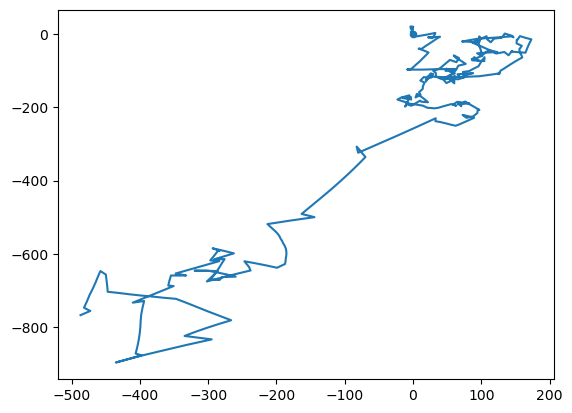

In [10]:
import matplotlib.pyplot as plt
plt.scatter(trajectory[0,0], trajectory[0,1], s = 20)
plt.plot(trajectory[:,0], trajectory[:,1])

In [4]:
pangolin.CreateWindowAndBind('Main', 640, 480)
gl.glEnable(gl.GL_DEPTH_TEST)

# Define Projection and initial ModelView matrix
scam = pangolin.OpenGlRenderState(
    pangolin.ProjectionMatrix(640, 480, 420, 420, 320, 240, 0.2, 200),
    pangolin.ModelViewLookAt(-2, 2, -2, 0, 0, 0, pangolin.AxisDirection.AxisY))
handler = pangolin.Handler3D(scam)

# Create Interactive View in window
dcam = pangolin.CreateDisplay()
dcam.SetBounds(0.0, 1.0, 0.0, 1.0, -640.0/480.0)
dcam.SetHandler(handler)


while not pangolin.ShouldQuit():
    gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
    gl.glClearColor(1.0, 1.0, 1.0, 1.0)
    dcam.Activate(scam)
    """
    # Render OpenGL Cube
    pangolin.glDrawColouredCube(0.1)

    # Draw Point Cloud
    points = np.random.random((10000, 3)) * 3 - 4
    gl.glPointSize(1)
    gl.glColor3f(1.0, 0.0, 0.0)
    pangolin.DrawPoints(points)
    
    # Draw Point Cloud
    points = np.random.random((10000, 3))
    colors = np.zeros((len(points), 3))
    colors[:, 1] = 1 -points[:, 0]
    colors[:, 2] = 1 - points[:, 1]
    colors[:, 0] = 1 - points[:, 2]
    points = points * 3 + 1
    gl.glPointSize(1)
    pangolin.DrawPoints(points, colors)
    """    
    # Draw lines
    gl.glLineWidth(1)
    gl.glColor3f(0.0, 0.0, 0.0)
    pangolin.DrawLine(trajectory)   # consecutive
    # Draw camera
    poses = np.array(poses)
    gl.glLineWidth(1)
    gl.glColor3f(0.0, 0.0, 1.0)
    pangolin.DrawCameras(poses, 0.03)
    """
    # Draw boxes
    poses = [np.identity(4) for i in range(10)]
    for pose in poses:
        pose[:3, 3] = np.random.randn(3) + np.array([5,-3,0])
    sizes = np.random.random((len(poses), 3))
    gl.glLineWidth(1)
    gl.glColor3f(1.0, 0.0, 1.0)
    pangolin.DrawBoxes(poses, sizes)

    """
    pangolin.FinishFrame()